In [4]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

rs = 0

In [5]:
feature_dfs = [pd.read_csv(f'output/feat_df_{str(i)}').drop('Unnamed: 0', axis=1) for i in range(6)]
combined_feats = pd.read_csv('output/combined_feats').drop('Unnamed: 0', axis=1)
train_scores = pd.read_csv('input/train_scores.csv')

In [3]:
X, y = combined_feats, train_scores['score']
X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=rs)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=.25, random_state=rs)
df_names = ['pattern info', 'n-gram tdidf', 'iki info', 'agg info', 'other count info', 'gap info']
y_trains = []
y_valids = []
for i, df in enumerate(feature_dfs):
    model = GradientBoostingRegressor()
    model.fit(X_train[df.columns], y_train)
    y_predict_train = model.predict(X_train[df.columns])
    y_predict_valid = model.predict(X_valid[df.columns])
    print(f'MSQE: validation set for {df_names[i]}: {round(mean_squared_error(y_valid, y_predict_valid, squared=False), 3)}')
    y_trains.append(y_predict_train)
    y_valids.append(y_predict_valid)

MSQE: validation set for pattern info: 0.82
MSQE: validation set for n-gram tdidf: 0.703
MSQE: validation set for iki info: 0.725
MSQE: validation set for agg info: 0.657
MSQE: validation set for other count info: 0.726
MSQE: validation set for gap info: 0.685


In [4]:
weights = [.1, .1, .1, .35, .1, .25]
y_train_combined, y_valids_combined = y_trains[0] * weights[0], y_valids[0] * weights[0]
for i in range(1, len(weights)):
    y_train_combined += y_trains[i] * weights[i]
    y_valids_combined += y_valids[i] * weights[i]
print(f'MSQE: training set, {round(mean_squared_error(y_train_combined, y_train, squared=False), 3)}')
print(f'MSQE: validation set for {df_names[i]}, {round(mean_squared_error(y_valids_combined, y_valid, squared=False), 3)}')

MSQE: training set, 0.467
MSQE: validation set for gap info, 0.626


In [130]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.svm import SVR
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from silence_tensorflow import silence_tensorflow
silence_tensorflow()
import tensorflow as tf

rs=0
X, y = combined_feats, train_scores['score']
X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=rs)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=.25, random_state=rs)

def print_results(model_name, gs):
    print(f'Best Score for {model_name}: {round(-gs.best_score_, 3)}, Best Params: {gs.best_params_}')

models = [
    {
        'name': 'Ridge',
        'model': Ridge,
        'params': {
            'alpha': [0, .1, 1, 10],
            'fit_intercept'    : [True, False]
        },
        'preprocess': lambda X: X
    },
    {
        'name': 'Ridge with Polynomial Features',
        'model': Ridge,
        'params': {
            'alpha': [0, .1, 1, 10],
            'fit_intercept': [True, False]
        },
        'preprocess': lambda X: PolynomialFeatures(degree=2).fit_transform(StandardScaler().fit_transform(X))
    },
        {
        'name': 'Lasso',
        'model': Lasso,
        'params': {
            'alpha': [0, .01, .1, .3],
            'fit_intercept'    : [True, False]
        },
        'preprocess': lambda X: X
    },
    {
        'name': 'Lasso with Polynomial Features',
        'model': Lasso,
        'params': {
            'alpha': [0, .01, .1, .3],
            'fit_intercept': [True, False]
        },
        'preprocess': lambda X: PolynomialFeatures(degree=2).fit_transform(StandardScaler().fit_transform(X))
    },
    {
        'name': 'KNN',
        'model': KNeighborsRegressor,
        'params': {
            'n_neighbors' : [1, 2, 3, 5, 10, 20, 50, 100]
        },
        'preprocess': lambda X: StandardScaler().fit_transform(X)
    },
    {
        'name': 'SVR',
        'model': SVR,
        'params': {
            'kernel' : ['linear', 'poly', 'rbf'],
            'C' : [.01, .1, 1],
            'degree' : [1, 2],
            'gamma' : [.01, .1, .5]
        },
        'preprocess': lambda X: StandardScaler().fit_transform(X)
    },
    {
        'name': 'GBR',
        'model': GradientBoostingRegressor,
        'params': {
            'n_estimators': [10, 50, 100, 200],
            'subsample': [.5, .65, .8, .9, 1],
            'max_depth': [2, 3, 8]
        },
        'preprocess': lambda X: X
    },
    {
        'name': 'LGBM',
        'model': LGBMRegressor,
        'params': {
            'subsample': [.5, .65, .8, .9, 1],
            'learning_rate': [0.1, 0.03, 0.003],
            'max_depth': [2, 3, 8],
            'n_estimators': [10, 50, 100, 200],
            'num_leaves': [131072]
        },
        'preprocess': lambda X: X.set_axis([str(i) for i in range(X.shape[1])], axis=1)
    },
    {
        'name': 'XGB',
        'model': XGBRegressor,
        'params': {
            'subsample': [.5, .65, .8, .9, 1],
            'learning_rate': [0.1, 0.03, 0.003],
            'max_depth': [2, 3, 8],
            'n_estimators': [10, 50, 100, 200],
        },
        'preprocess': lambda X: X
    },
]

def run_tests(cols):
    results = {}
    for model in models:
        gs = GridSearchCV(estimator=model['model'](), param_grid=model['params'], 
            scoring='neg_root_mean_squared_error', cv=4)
        gs.fit(model['preprocess'](X_train[cols]), y_train)
        print_results(model['name'], gs)
 
        # print_results('Ridge Model', gs)
        tuned_model = model['model'](**gs.best_params_)
        tuned_model.fit(model['preprocess'](X_train[cols]), y_train)
        y_pred = tuned_model.predict(model['preprocess'](X_valid[cols]))
        results[model['name']] = {
            'score': round(-gs.best_score_, 3), 
            'y_pred': y_pred,
            'model': tuned_model
        }

    model = tf.keras.Sequential([
        tf.keras.layers.Normalization(input_shape=[len(cols)]),
        tf.keras.layers.Dense(300, activation='relu'),
        tf.keras.layers.Dense(100, activation='relu'),
        tf.keras.layers.Dense(20, activation='relu'),
        tf.keras.layers.Dense(1)
    ])
    model.compile(loss='mse', optimizer='sgd', metrics=['RootMeanSquaredError'])
    model.fit(X_train[cols], y_train, epochs=30, validation_data=(X_valid[cols], y_valid))
    results['NN'] = {
        'score': round(model.evaluate(X_valid[cols], y_valid)[1], 3),
        'y_pred': model.predict(X_valid[cols]),
        'model': model
    }
    return results

Find ensemble model for pattern info

In [99]:
results_pattern = run_tests(feature_dfs[0].columns)
   
    

Best Score for Ridge: 0.933, Best Params: {'alpha': 10, 'fit_intercept': True}
Best Score for Ridge with Polynomial Features: 1.026, Best Params: {'alpha': 10, 'fit_intercept': True}
Best Score for Lasso: 0.929, Best Params: {'alpha': 0.01, 'fit_intercept': True}
Best Score for Lasso with Polynomial Features: 0.934, Best Params: {'alpha': 0.01, 'fit_intercept': True}
Best Score for KNN: 0.903, Best Params: {'n_neighbors': 50}
Best Score for SVR: 0.897, Best Params: {'C': 1, 'degree': 1, 'gamma': 0.1, 'kernel': 'rbf'}
Best Score for GBR: 0.875, Best Params: {'max_depth': 2, 'n_estimators': 50, 'subsample': 0.65}
Best Score for LGBM: 0.873, Best Params: {'learning_rate': 0.03, 'max_depth': 3, 'n_estimators': 200, 'num_leaves': 131072, 'subsample': 0.5}
Best Score for XGB: 0.874, Best Params: {'learning_rate': 0.03, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.65}
Epoch 1/30
47/47 [==============================] - 1s 9ms/step - loss: 2.6120 - root_mean_squared_error: 1.6162 - val_

In [103]:
changable_rs = 0
to_print = []
y_valid_preds_patterns = []
X, y = combined_feats, train_scores['score']
X, X_valid, y, y_valid = train_test_split(X, y, test_size=.2, random_state=changable_rs)
for model in models + [{'name': 'NN', 'preprocess': lambda X: X}]:
    tuned_model = results_pattern[model['name']]['model']
    y_pred = tuned_model.predict(model['preprocess'](X_valid[feature_dfs[0].columns]))
    y_valid_preds_patterns.append({
        'model': model['name'], 
        'features': 'patterns', 
        'y_valid_pred': y_pred if model['name'] != 'NN' else y_pred[:,0], 
        'score': mean_squared_error(y_pred, y_valid)})

weights = [0, 0, 0, 0, 0, 0, 0, 0, 1, 0]
y_valid_pred_pattern = []
for i in range(len(y_valid_preds_patterns)):
    sc = round(mean_squared_error(y_valid, y_valid_preds_patterns[i]['y_valid_pred']), 3)
    print(f'Validation score for model: {y_valid_preds_patterns[i]["model"]} -- {sc}')
for i in range(len(y_valid_preds_patterns)):
    vect = y_valid_preds_patterns[i]['y_valid_pred'] * weights[i]
    if i == 0:
        y_valid_pred_pattern = vect
    else:
        y_valid_pred_pattern = y_valid_pred_pattern + vect
sc = round(mean_squared_error(y_valid, y_valid_pred_pattern), 3)
print(f'Weighted ensemble of models for validation set: {sc}')


16/16 [==============================] - 0s 3ms/step
Validation score for model: Ridge -- 0.923
Validation score for model: Ridge with Polynomial Features -- 1.367
Validation score for model: Lasso -- 0.914
Validation score for model: Lasso with Polynomial Features -- 0.806
Validation score for model: KNN -- 0.766
Validation score for model: SVR -- 0.749
Validation score for model: GBR -- 0.743
Validation score for model: LGBM -- 0.745
Validation score for model: XGB -- 0.74
Validation score for model: NN -- 0.894
Weighted ensemble of models for validation set: 0.74


Find ensemble info for n-gram tdidf

In [104]:
results_ngram = run_tests(feature_dfs[1].columns)

Best Score for Ridge: 0.996, Best Params: {'alpha': 0, 'fit_intercept': True}
Best Score for Ridge with Polynomial Features: 1.476, Best Params: {'alpha': 10, 'fit_intercept': True}
Best Score for Lasso: 0.996, Best Params: {'alpha': 0, 'fit_intercept': True}
Best Score for Lasso with Polynomial Features: 0.876, Best Params: {'alpha': 0.01, 'fit_intercept': False}
Best Score for KNN: 1.095, Best Params: {'n_neighbors': 100}
Best Score for SVR: 0.76, Best Params: {'C': 1, 'degree': 1, 'gamma': 0.01, 'kernel': 'rbf'}
Best Score for GBR: 0.711, Best Params: {'max_depth': 2, 'n_estimators': 100, 'subsample': 1}
Best Score for LGBM: 0.71, Best Params: {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 200, 'num_leaves': 131072, 'subsample': 0.5}
Best Score for XGB: 0.712, Best Params: {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 100, 'subsample': 0.8}
Epoch 1/30
47/47 [==============================] - 1s 9ms/step - loss: 2.9456 - root_mean_squared_error: 1.7163 - val_loss: 1.

In [109]:
changable_rs = 0
X, y = combined_feats, train_scores['score']
X, X_valid, y, y_valid = train_test_split(X, y, test_size=.2, random_state=changable_rs)

y_valid_preds_ngrams = []
for model in models + [{'name': 'NN', 'preprocess': lambda X: X}]:
    tuned_model = results_ngram[model['name']]['model']
    y_pred = tuned_model.predict(model['preprocess'](X_valid[feature_dfs[1].columns]))
    y_valid_preds_ngrams.append({
        'model': model['name'], 
        'features': 'patterns', 
        'y_valid_pred': y_pred if model['name'] != 'NN' else y_pred[:,0], 
        'score': mean_squared_error(y_pred, y_valid)})

weights = [0, 0, 0, 0, 0, 0, 0, 1, 0, 0]
y_valid_pred_ngram = []
for i in range(len(y_valid_preds_ngrams)):
    sc = round(mean_squared_error(y_valid, y_valid_preds_ngrams[i]['y_valid_pred']), 3)
    print(f'Validation score for model: {y_valid_preds_ngrams[i]["model"]} -- {sc}')
for i in range(len(y_valid_preds_ngrams)):
    vect = y_valid_preds_ngrams[i]['y_valid_pred'] * weights[i]
    if i == 0:
        y_valid_pred_ngram = vect
    else:
        y_valid_pred_ngram = y_valid_pred_ngram + vect
sc = round(mean_squared_error(y_valid, y_valid_pred_ngram), 3)
print(f'Weighted ensemble of models for validation set: {sc}')

16/16 [==============================] - 0s 3ms/step
Validation score for model: Ridge -- 0.951
Validation score for model: Ridge with Polynomial Features -- 1.22
Validation score for model: Lasso -- 0.951
Validation score for model: Lasso with Polynomial Features -- 0.602
Validation score for model: KNN -- 1.069
Validation score for model: SVR -- 0.523
Validation score for model: GBR -- 0.447
Validation score for model: LGBM -- 0.432
Validation score for model: XGB -- 0.439
Validation score for model: NN -- 0.979
Weighted ensemble of models for validation set: 0.432


Next, try this with iki info

In [113]:
results_iki = run_tests(feature_dfs[2].columns)

Best Score for Ridge: 0.759, Best Params: {'alpha': 0.1, 'fit_intercept': False}
Best Score for Ridge with Polynomial Features: 1.733, Best Params: {'alpha': 10, 'fit_intercept': False}
Best Score for Lasso: 0.758, Best Params: {'alpha': 0, 'fit_intercept': False}
Best Score for Lasso with Polynomial Features: 0.794, Best Params: {'alpha': 0.1, 'fit_intercept': True}
Best Score for KNN: 0.763, Best Params: {'n_neighbors': 20}
Best Score for SVR: 0.719, Best Params: {'C': 1, 'degree': 1, 'gamma': 0.01, 'kernel': 'rbf'}
Best Score for GBR: 0.719, Best Params: {'max_depth': 2, 'n_estimators': 100, 'subsample': 0.65}
Best Score for LGBM: 0.719, Best Params: {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 100, 'num_leaves': 131072, 'subsample': 0.5}
Best Score for XGB: 0.716, Best Params: {'learning_rate': 0.03, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.5}
Epoch 1/30
47/47 [==============================] - 1s 8ms/step - loss: nan - root_mean_squared_error: nan - val_loss: 

In [117]:
changable_rs = 0
X, y = combined_feats, train_scores['score']
X, X_valid, y, y_valid = train_test_split(X, y, test_size=.2, random_state=changable_rs)

y_valid_preds_iki = []
for model in models:
    tuned_model = results_iki[model['name']]['model']
    y_pred = tuned_model.predict(model['preprocess'](X_valid[feature_dfs[2].columns]))
    y_valid_preds_iki.append({
        'model': model['name'], 
        'features': 'iki', 
        'y_valid_pred': y_pred if model['name'] != 'NN' else y_pred[:,0], 
        'score': mean_squared_error(y_pred, y_valid)})

weights = [0, 0, 0, 0, 0, 0, 0, 1, 0]
y_valid_pred_iki = []
for i in range(len(y_valid_preds_iki)):
    sc = round(mean_squared_error(y_valid, y_valid_preds_iki[i]['y_valid_pred']), 3)
    print(f'Validation score for model: {y_valid_preds_iki[i]["model"]} -- {sc}')
for i in range(len(y_valid_preds_iki)):
    vect = y_valid_preds_iki[i]['y_valid_pred'] * weights[i]
    if i == 0:
        y_valid_pred_iki = vect
    else:
        y_valid_pred_iki = y_valid_pred_iki + vect
sc = round(mean_squared_error(y_valid, y_valid_pred_iki), 3)
print(f'Weighted ensemble of models for validation set: {sc}')

Validation score for model: Ridge -- 0.525
Validation score for model: Ridge with Polynomial Features -- 0.779
Validation score for model: Lasso -- 0.533
Validation score for model: Lasso with Polynomial Features -- 0.548
Validation score for model: KNN -- 0.53
Validation score for model: SVR -- 0.508
Validation score for model: GBR -- 0.468
Validation score for model: LGBM -- 0.486
Validation score for model: XGB -- 0.469
Weighted ensemble of models for validation set: 0.486


Repeat the step for the aggregate info feature df

In [92]:
results_agg = run_tests(feature_dfs[3].columns)

Best Score for Ridge: 0.667, Best Params: {'alpha': 0, 'fit_intercept': True}
Best Score for Ridge with Polynomial Features: 1.687, Best Params: {'alpha': 10, 'fit_intercept': False}
Best Score for Lasso: 0.679, Best Params: {'alpha': 0, 'fit_intercept': True}
Best Score for Lasso with Polynomial Features: 0.775, Best Params: {'alpha': 0.1, 'fit_intercept': True}
Best Score for KNN: 0.705, Best Params: {'n_neighbors': 20}
Best Score for SVR: 0.666, Best Params: {'C': 1, 'degree': 1, 'gamma': 0.01, 'kernel': 'rbf'}
Best Score for GBR: 0.641, Best Params: {'max_depth': 3, 'n_estimators': 50, 'subsample': 0.9}
Best Score for LGBM: 0.645, Best Params: {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 100, 'num_leaves': 131072, 'subsample': 0.5}
Best Score for XGB: 0.641, Best Params: {'learning_rate': 0.03, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.9}
Epoch 1/30
47/47 [==============================] - 1s 9ms/step - loss: nan - root_mean_squared_error: nan - val_loss: nan - 

In [126]:
changable_rs = 0
X, y = combined_feats, train_scores['score']
X, X_valid, y, y_valid = train_test_split(X, y, test_size=.2, random_state=changable_rs)

y_valid_preds_agg = []
for model in models:
    tuned_model = results_agg[model['name']]['model']
    y_pred = tuned_model.predict(model['preprocess'](X_valid[feature_dfs[3].columns]))
    y_valid_preds_agg.append({
        'model': model['name'], 
        'features': 'agg', 
        'y_valid_pred': y_pred if model['name'] != 'NN' else y_pred[:,0], 
        'score': mean_squared_error(y_pred, y_valid)})

weights = [0.5, 0, 0, 0, 0, 0, .5, 0, 0]
y_valid_pred_agg = []
for i in range(len(y_valid_preds_agg)):
    sc = round(mean_squared_error(y_valid, y_valid_preds_agg[i]['y_valid_pred']), 3)
    print(f'Validation score for model: {y_valid_preds_agg[i]["model"]} -- {sc}')
for i in range(len(y_valid_preds_agg)):
    vect = y_valid_preds_agg[i]['y_valid_pred'] * weights[i]
    if i == 0:
        y_valid_pred_agg = vect
    else:
        y_valid_pred_agg = y_valid_pred_agg + vect
sc = round(mean_squared_error(y_valid, y_valid_pred_agg), 3)
print(f'Weighted ensemble of models for validation set: {sc}')

Validation score for model: Ridge -- 0.392
Validation score for model: Ridge with Polynomial Features -- 1.396
Validation score for model: Lasso -- 0.412
Validation score for model: Lasso with Polynomial Features -- 0.461
Validation score for model: KNN -- 0.415
Validation score for model: SVR -- 0.388
Validation score for model: GBR -- 0.411
Validation score for model: LGBM -- 0.418
Validation score for model: XGB -- 0.408
Weighted ensemble of models for validation set: 0.378


Next, other count info

In [131]:
results_other = run_tests(feature_dfs[4].columns)

Best Score for Ridge: 0.875, Best Params: {'alpha': 0, 'fit_intercept': True}
Best Score for Ridge with Polynomial Features: 0.966, Best Params: {'alpha': 10, 'fit_intercept': False}
Best Score for Lasso: 0.875, Best Params: {'alpha': 0, 'fit_intercept': True}
Best Score for Lasso with Polynomial Features: 0.84, Best Params: {'alpha': 0.01, 'fit_intercept': False}
Best Score for KNN: 0.865, Best Params: {'n_neighbors': 20}
Best Score for SVR: 0.815, Best Params: {'C': 1, 'degree': 1, 'gamma': 0.1, 'kernel': 'rbf'}
Best Score for GBR: 0.761, Best Params: {'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
Best Score for LGBM: 0.762, Best Params: {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 100, 'num_leaves': 131072, 'subsample': 0.5}
Best Score for XGB: 0.759, Best Params: {'learning_rate': 0.03, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.65}
Epoch 1/30
47/47 [==============================] - 1s 9ms/step - loss: 3.8100 - root_mean_squared_error: 1.9519 - val_loss

In [138]:
changable_rs = 0
X, y = combined_feats, train_scores['score']
X, X_valid, y, y_valid = train_test_split(X, y, test_size=.2, random_state=changable_rs)

y_valid_preds_other = []
for model in models + [{'name': 'NN', 'preprocess': lambda X: X}]:
    tuned_model = results_other[model['name']]['model']
    y_pred = tuned_model.predict(model['preprocess'](X_valid[feature_dfs[4].columns]))
    y_valid_preds_other.append({
        'model': model['name'], 
        'features': 'other count info', 
        'y_valid_pred': y_pred if model['name'] != 'NN' else y_pred[:,0], 
        'score': mean_squared_error(y_pred, y_valid)})

weights = [0, 0, 0, 0, 0, 0, .5, 0, .5, 0]
y_valid_pred_other = []
for i in range(len(y_valid_preds_other)):
    sc = round(mean_squared_error(y_valid, y_valid_preds_other[i]['y_valid_pred']), 3)
    print(f'Validation score for model: {y_valid_preds_other[i]["model"]} -- {sc}')
for i in range(len(y_valid_preds_other)):
    vect = y_valid_preds_other[i]['y_valid_pred'] * weights[i]
    if i == 0:
        y_valid_pred_other = vect
    else:
        y_valid_pred_other = y_valid_pred_other + vect
sc = round(mean_squared_error(y_valid, y_valid_pred_other), 3)
print(f'Weighted ensemble of models for validation set: {sc}')

16/16 [==============================] - 0s 6ms/step
Validation score for model: Ridge -- 1.038
Validation score for model: Ridge with Polynomial Features -- 2.176
Validation score for model: Lasso -- 1.038
Validation score for model: Lasso with Polynomial Features -- 0.787
Validation score for model: KNN -- 0.691
Validation score for model: SVR -- 0.636
Validation score for model: GBR -- 0.571
Validation score for model: LGBM -- 0.588
Validation score for model: XGB -- 0.567
Validation score for model: NN -- 0.939
Weighted ensemble of models for validation set: 0.564


Finally, run tests for gap info df

In [139]:
results_gap = run_tests(feature_dfs[5].columns)

Best Score for Ridge: 0.722, Best Params: {'alpha': 10, 'fit_intercept': True}
Best Score for Ridge with Polynomial Features: 1.201, Best Params: {'alpha': 10, 'fit_intercept': True}
Best Score for Lasso: 0.718, Best Params: {'alpha': 0.01, 'fit_intercept': True}
Best Score for Lasso with Polynomial Features: 0.704, Best Params: {'alpha': 0.01, 'fit_intercept': True}
Best Score for KNN: 0.712, Best Params: {'n_neighbors': 20}
Best Score for SVR: 0.69, Best Params: {'C': 1, 'degree': 1, 'gamma': 0.01, 'kernel': 'rbf'}
Best Score for GBR: 0.673, Best Params: {'max_depth': 3, 'n_estimators': 50, 'subsample': 0.65}
Best Score for LGBM: 0.672, Best Params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'num_leaves': 131072, 'subsample': 0.5}
Best Score for XGB: 0.668, Best Params: {'learning_rate': 0.03, 'max_depth': 2, 'n_estimators': 200, 'subsample': 0.5}
Epoch 1/30
47/47 [==============================] - 1s 8ms/step - loss: nan - root_mean_squared_error: nan - val_loss: nan

In [147]:
changable_rs = 0
X, y = combined_feats, train_scores['score']
X, X_valid, y, y_valid = train_test_split(X, y, test_size=.2, random_state=changable_rs)

y_valid_preds_gap = []
for model in models:
    tuned_model = results_gap[model['name']]['model']
    y_pred = tuned_model.predict(model['preprocess'](X_valid[feature_dfs[5].columns]))
    y_valid_preds_gap.append({
        'model': model['name'], 
        'features': 'other count info', 
        'y_valid_pred': y_pred if model['name'] != 'NN' else y_pred[:,0], 
        'score': mean_squared_error(y_pred, y_valid)})

weights = [0, 0, 0, 0, 0, 0, 0, 0, 1]
y_valid_pred_gap = []
for i in range(len(y_valid_preds_gap)):
    sc = round(mean_squared_error(y_valid, y_valid_preds_gap[i]['y_valid_pred']), 3)
    print(f'Validation score for model: {y_valid_preds_gap[i]["model"]} -- {sc}')
for i in range(len(y_valid_preds_gap)):
    vect = y_valid_preds_gap[i]['y_valid_pred'] * weights[i]
    if i == 0:
        y_valid_pred_gap = vect
    else:
        y_valid_pred_gap = y_valid_pred_gap + vect
sc = round(mean_squared_error(y_valid, y_valid_pred_gap), 3)
print(f'Weighted ensemble of models for validation set: {sc}')

Validation score for model: Ridge -- 0.468
Validation score for model: Ridge with Polynomial Features -- 0.752
Validation score for model: Lasso -- 0.469
Validation score for model: Lasso with Polynomial Features -- 0.468
Validation score for model: KNN -- 0.479
Validation score for model: SVR -- 0.455
Validation score for model: GBR -- 0.414
Validation score for model: LGBM -- 0.425
Validation score for model: XGB -- 0.411
Weighted ensemble of models for validation set: 0.411


Now, try to combine the best from all these results:

Best score for pattern model: 0.74
Best score for ngram tdidf model: 0.432
Best score for iki model: 0.486
Best score for agg model: 0.378
Best score for other model: 0.564
Best score for gap model: 0.411


0.35

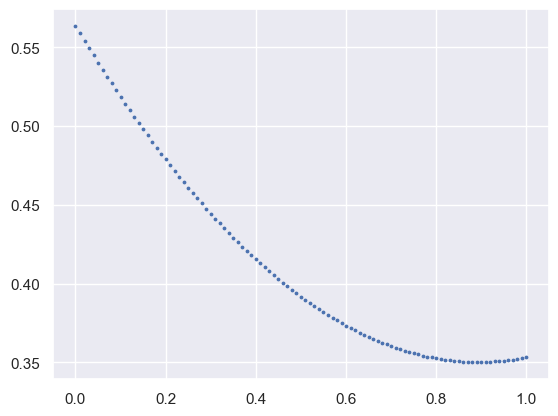

In [156]:
ensemble_preds = [
    (y_valid_pred_pattern, 'pattern'),
    (y_valid_pred_ngram, 'ngram tdidf'),
    (y_valid_pred_iki, 'iki'),
    (y_valid_pred_agg, 'agg'),
    (y_valid_pred_other, 'other'),
    (y_valid_pred_gap, 'gap')
]
for i in range(len(ensemble_preds)):
    sc = round(mean_squared_error(y_valid, ensemble_preds[i][0]), 3)
    print(f'Best score for {ensemble_preds[i][1]} model: {sc}')
scores = []
iotas = np.arange(0, 1.01, .01)
for iota in iotas:
    scores.append(mean_squared_error(y_valid, y_valid_pred_agg * iota + y_valid_pred_gap * (1 - iota)))
ens = y_valid_pred_agg * .65 + y_valid_pred_gap * .35
scores = []
for iota in iotas:
    scores.append(mean_squared_error(y_valid, ens * iota + y_valid_pred_ngram * (1 - iota)))
ens = ens * .7 + y_valid_pred_ngram * .3
scores = []
for iota in iotas:
    scores.append(mean_squared_error(y_valid, ens * iota + y_valid_pred_other * (1 - iota)))
plt.scatter(iotas, scores, s=3)
ens = ens * .9 + y_valid_pred_other * .1
round(mean_squared_error(y_valid, ens), 3)